Directorio de ROIs: /home/diego/Escritorio/AAL3/ROISignals_AAL3_NiftiPreprocessedAllBatchesNorm
Archivo CSV de metadatos de sujetos: /home/diego/Escritorio/AAL3/SubjctsDataAndTests_Schaefer2018_400Parcels_17Networks.csv
Archivo de metadatos AAL3: /home/diego/Escritorio/AAL3/ROI_MNI_V7_vol.txt
Directorio de exportación: qc_outputs_doctoral_v3.2_aal3_shrinkage_flexible_thresh_fix
Columnas esperadas en .mat: 170
ROIs esperados tras limpieza AAL3: 166
Umbral de exclusión de ROIs pequeños (voxels): 100

--- Iniciando Bloque 0: Carga de Metadatos AAL3 ---
Metadatos AAL3 cargados: 166 entradas.
Se identificaron 166 ROIs válidos de AAL3 (después de excluir los 4 faltantes).
--- Bloque 0 Completado ---

--- Iniciando Bloque 1: Carga de Metadatos de Sujetos ---
Total de sujetos en CSV: 434
--- Bloque 1 Completado ---

--- Iniciando Bloque 3: QC Inicial por Sujeto ---

=== Estadísticas Descriptivas del QC Inicial (Raw Data) ===
                   count        mean           std         min       

/home/diego/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/diego/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/diego/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/diego/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert in

Número de sujetos válidos después del QC inicial: 434
--- Bloque 3 Completado ---

--- Iniciando Bloque 4: Detección de Outliers Univariantes ---

=== Estadísticas Descriptivas de Outliers Univariantes ===
                      count         mean          std         min         25%  \
UnivOutliersCount     434.0    49.834101    51.422132    1.000000   19.000000   
UnivOutliersPct       434.0     0.167764     0.160809    0.004303    0.067274   
MeanOriginalVariance  434.0  1599.049154  2270.608108  326.233105  906.836310   

                              50%          75%           max  
UnivOutliersCount       35.000000    63.000000    487.000000  
UnivOutliersPct          0.119259     0.204880      1.489206  
MeanOriginalVariance  1232.037290  1725.116796  40142.967181  
--- Bloque 4 Completado ---

--- Iniciando Bloque 5: Procesamiento de ROIs y Outliers Multivariantes ---
  INFO (Sujeto 002_S_0295): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujet

/home/diego/anaconda3/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


  INFO (Sujeto 006_S_4150): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 006_S_4153): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 006_S_4192): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 006_S_4346): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 006_S_4357): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 006_S_4363): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 006_S_4449): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 006_S_4485): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 006_S_4546): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 006_S_4679): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Su

/home/diego/anaconda3/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


  INFO (Sujeto 010_S_4135): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 010_S_4442): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 010_S_5163): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%


/home/diego/anaconda3/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/home/diego/anaconda3/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


  INFO (Sujeto 012_S_4026): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 012_S_4094): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 012_S_4128): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 012_S_4188): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 012_S_4643): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 012_S_4849): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 012_S_4987): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%


/home/diego/anaconda3/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


  INFO (Sujeto 013_S_1186): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 013_S_2324): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 013_S_2389): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 013_S_4236): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 013_S_4268): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 013_S_4395): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 013_S_4580): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 013_S_4595): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 013_S_4616): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 013_S_4731): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Su

/home/diego/anaconda3/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/home/diego/anaconda3/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/home/diego/anaconda3/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


  INFO (Sujeto 018_S_2133): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 018_S_2155): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 018_S_2180): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 018_S_4257): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 018_S_4313): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 018_S_4349): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 018_S_4400): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 018_S_4597): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 018_S_4696): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 018_S_4733): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Su

/home/diego/anaconda3/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/home/diego/anaconda3/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


  INFO (Sujeto 031_S_2018): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 031_S_2022): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 031_S_2233): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 031_S_4005): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 031_S_4024): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 031_S_4029): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 031_S_4032): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 031_S_4042): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 031_S_4149): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 031_S_4194): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Su

/home/diego/anaconda3/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/home/diego/anaconda3/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/home/diego/anaconda3/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/home/diego/anaconda3/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/home/diego/anaconda3/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/home/diego/anaconda3/lib/python3.1

  INFO (Sujeto 053_S_0919): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 053_S_2357): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 053_S_2396): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 053_S_4557): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 053_S_4578): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 053_S_4661): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 053_S_4813): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 053_S_5070): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 053_S_5208): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%


/home/diego/anaconda3/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/home/diego/anaconda3/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/home/diego/anaconda3/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


  INFO (Sujeto 100_S_2351): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 100_S_4469): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 100_S_4511): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 100_S_4512): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 100_S_4556): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 100_S_4884): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 100_S_4970): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 100_S_5106): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 100_S_5246): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%


/home/diego/anaconda3/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/home/diego/anaconda3/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/home/diego/anaconda3/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/home/diego/anaconda3/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/home/diego/anaconda3/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/home/diego/anaconda3/lib/python3.1

  INFO (Sujeto 130_S_2391): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 130_S_2402): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 130_S_2403): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 130_S_4294): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 130_S_4343): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 130_S_4352): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 130_S_4405): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 130_S_4415): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 130_S_4417): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 130_S_4468): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Su

/home/diego/anaconda3/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/home/diego/anaconda3/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


  INFO (Sujeto 131_S_5138): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%


/home/diego/anaconda3/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/home/diego/anaconda3/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


  INFO (Sujeto 136_S_4269): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 136_S_4408): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 136_S_4433): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 136_S_4517): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 136_S_4726): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 136_S_4727): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 136_S_4836): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 136_S_4848): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 136_S_4932): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Sujeto 136_S_4956): Usando Ledoit-Wolf (TPs=140, ROIs=131). Calculado % outliers MV: 0.00%
  INFO (Su

/home/diego/anaconda3/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/home/diego/anaconda3/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(



=== Estadísticas Descriptivas de Outliers Multivariantes ===
                 count       mean        std  min  25%        50%        75%  \
MVOutliersCount  434.0  20.811060  15.544506  0.0  0.0  32.000000  32.000000   
MVOutliersPct    434.0  10.534656   7.865803  0.0  0.0  16.243655  16.243655   

                  max  
MVOutliersCount  38.0  
MVOutliersPct    19.0  

Conteo de razones por las que se omitió el análisis MV:
MVAnalysisSkipped
None    434
Name: count, dtype: int64

Conteo de métodos de análisis MV usados:
MVAnalysisMethod
MCD           279
LedoitWolf    155
Name: count, dtype: int64

Conteo de ROIs usados para análisis MV (para los que se intentó):
ROIs_for_MV
131    434
Name: count, dtype: int64
--- Bloque 5 Completado ---

--- Iniciando Bloque 6: Combinación de Métricas y Visualizaciones Globales ---

Reporte completo guardado en: qc_outputs_doctoral_v3.2_aal3_shrinkage_flexible_thresh_fix/report_qc_full_compiled_v3.2.csv
--- Bloque 6 Completado ---

--- Iniciando 

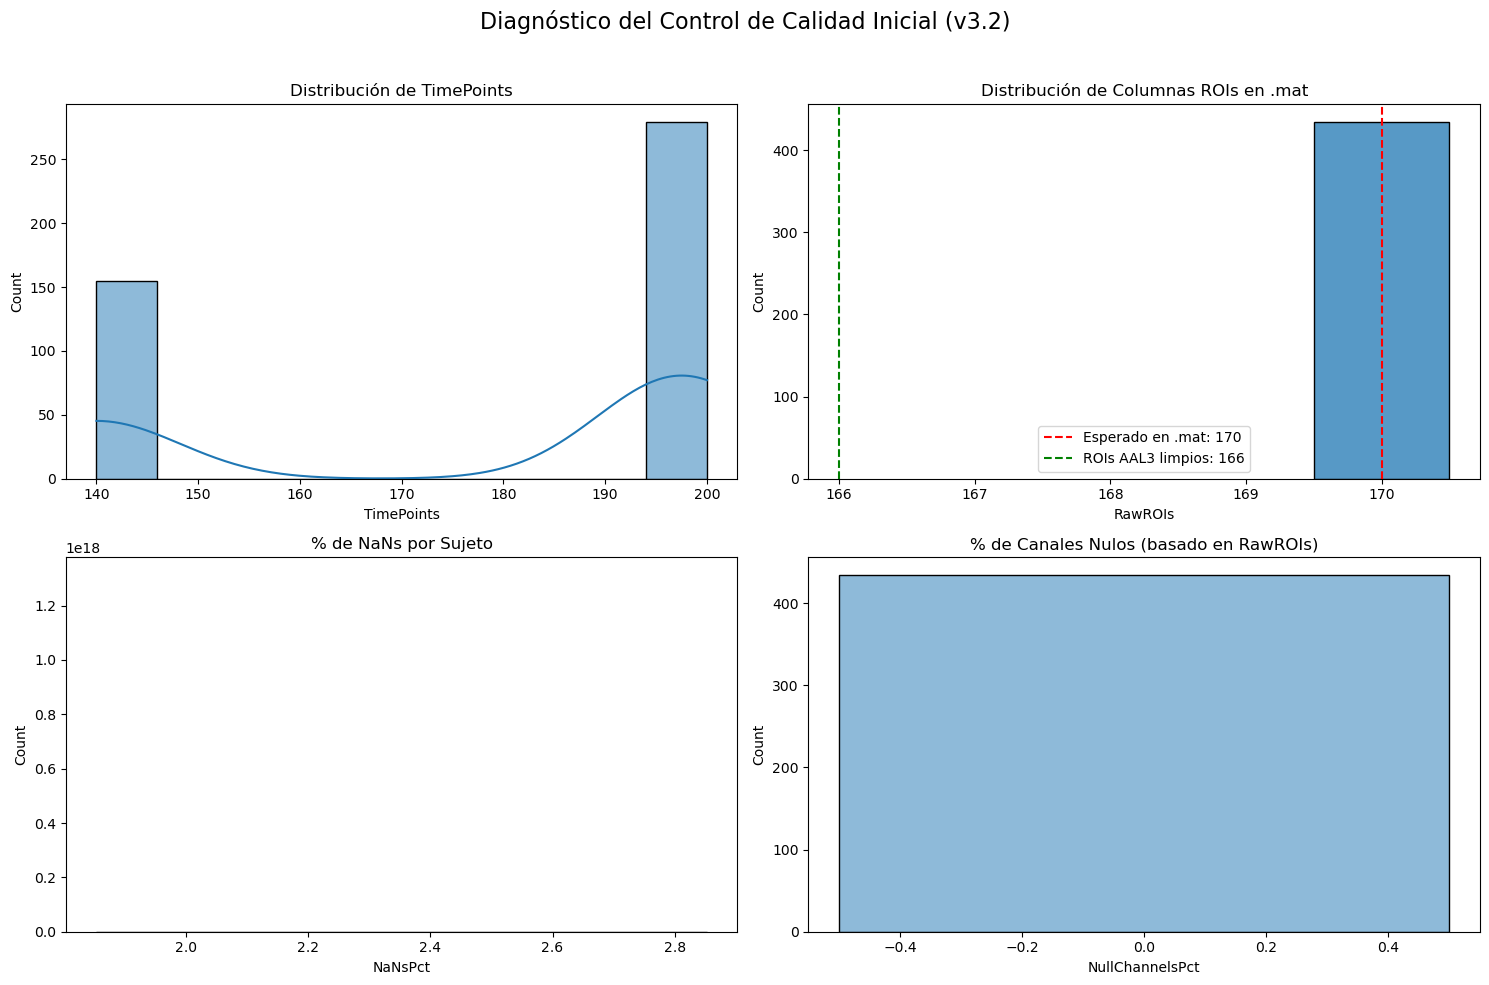

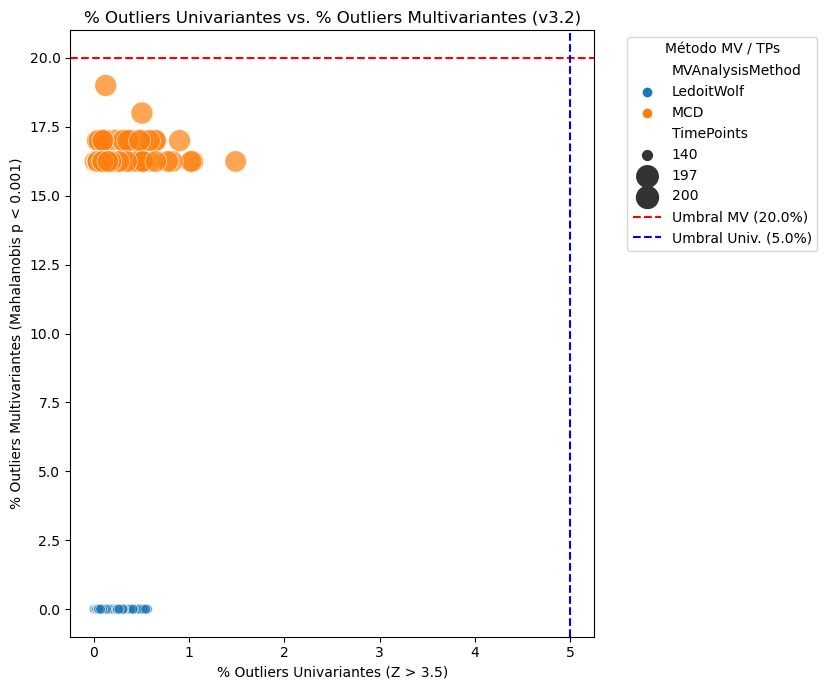

In [1]:
# ANÁLISIS DOCTORAL DE OUTLIERS EN SERIES BOLD (v3.2 - AAL3 Aware + Shrinkage + Umbrales Flexibles + Corrección LinAlgWarning)
# --------------------------------------------------------------------------------------------------------------------------
# Refinamientos v3.2:
# - Corregido NameError: 'LinAlgWarning' no estaba definido. Importado de numpy.linalg.
# Refinamientos v3.1:
# - Umbral de outliers univariantes basado en un porcentaje absoluto configurable.
# - Cálculo de % de outliers multivariantes (Mahalanobis) para sujetos procesados con Ledoit-Wolf.
# - Ajustes en configuración para facilitar la retención de más sujetos.
# Refinamientos v3:
# - Integración de estimación de covarianza Ledoit-Wolf para N < d.
# - Carga y uso de ROI_MNI_V7_vol.txt para:
#   - Excluir 4 ROIs faltantes/vacíos específicos de AAL3.
#   - Excluir ROIs con volumen < SMALL_ROI_VOXEL_THRESHOLD.
# - Aplicación de z-score a los datos antes de MCD/Ledoit-Wolf.
# - Cálculo y almacenamiento de la varianza original por ROI.
# - Opción de umbral univariante basado en MAD.
# - Placeholders para métricas adicionales (DVARS, FD, tSNR, MRIQC_score).
# - Ajustes en la lógica de exclusión y configuración.

import os
from pathlib import Path
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore, chi2, median_abs_deviation
from sklearn.covariance import MinCovDet, LedoitWolf
from sklearn.impute import SimpleImputer
import warnings
from numpy.linalg import LinAlgError # Importar LinAlgError para el manejo de excepciones
# Importar LinAlgWarning para el filtro de advertencias
try:
    from numpy.linalg import LinAlgWarning
except ImportError: # Para versiones más antiguas de NumPy donde podría no estar exportada directamente o no existir
    class LinAlgWarning(Warning): pass


# --- Ignorar UserWarnings (opcional) ---
# warnings.filterwarnings("ignore", category=UserWarning, module='sklearn.covariance._robust_covariance')
# warnings.filterwarnings("ignore", category=RuntimeWarning) # Para nanvar de slices con NaNs, y otras advertencias de scipy/numpy

# ---------- CONFIGURACIÓN ----------
ROI_DIR = Path('/home/diego/Escritorio/AAL3/ROISignals_AAL3_NiftiPreprocessedAllBatchesNorm')
CSV_PATH = Path('/home/diego/Escritorio/AAL3/SubjctsDataAndTests_Schaefer2018_400Parcels_17Networks.csv')
AAL3_META_PATH = Path('/home/diego/Escritorio/AAL3/ROI_MNI_V7_vol.txt') # Ruta al archivo de metadatos de AAL3

RAW_DATA_EXPECTED_COLUMNS = 170 # Columnas esperadas en .mat (AAL3 completo)
AAL3_MISSING_INDICES_1BASED = [35, 36, 81, 82] # Índices 'color' (1-based) de AAL3 que están vacíos/faltantes
EXPECTED_ROIS_AFTER_AAL3_CLEANUP = RAW_DATA_EXPECTED_COLUMNS - len(AAL3_MISSING_INDICES_1BASED) # Debería ser 166

SMALL_ROI_VOXEL_THRESHOLD = 100 # Umbral para excluir ROIs pequeños (vol_vox)

Z_THRESHOLD_UNIV = 3.5
# Para outliers univariantes, usar un umbral de porcentaje absoluto:
UNIV_OUTLIER_PCT_ABSOLUTE_THRESHOLD_VALUE = 5.0 # Ej: descartar si >5% de los puntos son outliers univariantes. AJUSTAR SEGÚN NECESIDAD.

ALPHA_MAHAL = 0.001 # p-valor para outliers multivariantes (usado en el cálculo de la distancia crítica)

MIN_TP_FOR_LEDOITWOLF = 50 # Mínimo TPs para intentar Ledoit-Wolf
MIN_TP_FOR_MCD_STRICT_FACTOR = 1.1 # Factor para MCD: TPs > ROIs_for_MV * factor
MIN_TIMEPOINTS_FOR_ANY_MV = 30 # Umbral absoluto mínimo de TPs para cualquier análisis MV (MCD o Ledoit)

EXPORT_DIR = Path('./qc_outputs_doctoral_v3.2_aal3_shrinkage_flexible_thresh_fix')

# --- Criterios de Exclusión (Ajustables) ---
TP_THRESHOLD_VALUE = 140 # Umbral ABSOLUTO de TPs para mantener un sujeto.
# Para outliers multivariantes, umbral de porcentaje absoluto:
MV_OUTLIER_PCT_ABSOLUTE_THRESHOLD = 20.0 # Ej: descartar si >20% de TPs son outliers MV. AJUSTAR SEGÚN NECESIDAD.
                                        # El valor anterior de 10.0 era muy restrictivo.
NANS_PCT_ABSOLUTE_THRESHOLD = 5.0
NULL_CHANNELS_PCT_ABSOLUTE_THRESHOLD = 1.0 # Para canales nulos en datos crudos (170 ROIs)
EXCLUDE_IF_MV_SKIPPED_INSUFFICIENT_DATA = True # ¿Excluir si análisis MV fue omitido por TPs <= ROIs_processed?

# Crear directorio de exportación
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Directorio de ROIs: {ROI_DIR}")
print(f"Archivo CSV de metadatos de sujetos: {CSV_PATH}")
print(f"Archivo de metadatos AAL3: {AAL3_META_PATH}")
print(f"Directorio de exportación: {EXPORT_DIR}")
print(f"Columnas esperadas en .mat: {RAW_DATA_EXPECTED_COLUMNS}")
print(f"ROIs esperados tras limpieza AAL3: {EXPECTED_ROIS_AFTER_AAL3_CLEANUP}")
print(f"Umbral de exclusión de ROIs pequeños (voxels): {SMALL_ROI_VOXEL_THRESHOLD}\n")

# ---------- 0. CARGA DE METADATOS AAL3 ----------
print("--- Iniciando Bloque 0: Carga de Metadatos AAL3 ---")
try:
    meta_aal3_df = pd.read_csv(AAL3_META_PATH, sep='\t')
    meta_aal3_df['color'] = pd.to_numeric(meta_aal3_df['color'], errors='coerce')
    meta_aal3_df.dropna(subset=['color'], inplace=True)
    meta_aal3_df['color'] = meta_aal3_df['color'].astype(int)
    
    print(f"Metadatos AAL3 cargados: {len(meta_aal3_df)} entradas.")
    required_aal3_cols = ['nom_c', 'color', 'vol_vox']
    if not all(col in meta_aal3_df.columns for col in required_aal3_cols):
        raise ValueError(f"El archivo de metadatos AAL3 debe contener las columnas: {required_aal3_cols}")
    
    valid_aal3_rois_info = meta_aal3_df[~meta_aal3_df['color'].isin(AAL3_MISSING_INDICES_1BASED)].copy()
    valid_aal3_rois_info.sort_values(by='color', inplace=True)
    valid_aal3_rois_info.reset_index(drop=True, inplace=True)

    if len(valid_aal3_rois_info) != EXPECTED_ROIS_AFTER_AAL3_CLEANUP:
        print(f"ADVERTENCIA: Se esperaban {EXPECTED_ROIS_AFTER_AAL3_CLEANUP} ROIs válidos tras filtrar los faltantes de AAL3, pero se encontraron {len(valid_aal3_rois_info)} en {AAL3_META_PATH}.")
    else:
        print(f"Se identificaron {len(valid_aal3_rois_info)} ROIs válidos de AAL3 (después de excluir los {len(AAL3_MISSING_INDICES_1BASED)} faltantes).")

except Exception as e:
    print(f"Error cargando metadatos AAL3 de {AAL3_META_PATH}: {e}")
    exit()
print("--- Bloque 0 Completado ---\n")

# ---------- FUNCIONES AUXILIARES DE UMBRAL (IQR/STD/MAD - no usadas directamente para UnivOutliersPct ahora) ----------
def iqr_threshold_upper(series: pd.Series, multiplier: float = 1.5) -> float:
    if series.empty or series.isna().all(): return np.nan
    q1, q3 = series.quantile([0.25, 0.75])
    if pd.isna(q1) or pd.isna(q3): return np.nan
    iqr = q3 - q1
    return q3 + multiplier * iqr

def std_threshold_upper(series: pd.Series, multiplier: float = 3.0) -> float:
    if series.empty or series.isna().all(): return np.nan
    mean_val, std_val = series.mean(), series.std()
    if pd.isna(mean_val) or pd.isna(std_val): return np.nan
    return mean_val + multiplier * std_val

def mad_threshold_upper(series: pd.Series, multiplier: float = 3.0) -> float:
    if series.empty or series.isna().all(): return np.nan
    median_val = series.median()
    mad_val_raw = (series.dropna() - median_val).abs().median()
    mad_val_scaled = mad_val_raw * 1.4826 
    if pd.isna(median_val) or pd.isna(mad_val_scaled) or mad_val_scaled == 0:
        print("Advertencia: MAD es 0, usando std para umbral univariante.")
        return std_threshold_upper(series, multiplier)
    return median_val + multiplier * mad_val_scaled

# ---------- 1. CARGA DE METADATOS DE SUJETOS Y RUTAS .mat ----------
print("--- Iniciando Bloque 1: Carga de Metadatos de Sujetos ---")
try:
    meta_df = pd.read_csv(CSV_PATH)
    SUBJECT_ID_COL = 'SubjectID' 
    meta_df[SUBJECT_ID_COL] = meta_df[SUBJECT_ID_COL].astype(str).str.strip()
    meta_df['MatPath'] = meta_df[SUBJECT_ID_COL].apply(lambda sid: ROI_DIR / f'ROISignals_{sid}.mat')
    meta_df['MatExists'] = meta_df['MatPath'].apply(lambda p: p.exists())
    subjects_with_mat = meta_df[meta_df['MatExists']].copy()
    # ... (resto de las verificaciones del CSV)
    if len(subjects_with_mat) == 0:
        raise FileNotFoundError("No se encontraron archivos .mat para ningún sujeto listado.")
    print(f"Total de sujetos en CSV: {len(meta_df)}")
    print("--- Bloque 1 Completado ---\n")
except Exception as e:
    print(f"Error en Bloque 1: {e}")
    exit()

# ---------- 2. FUNCIÓN DE QC INICIAL ----------
def qc_initial_subject(mat_path: Path, subject_id: str, raw_expected_cols: int):
    try:
        data = sio.loadmat(str(mat_path))
        signals_key = 'signals'
        if signals_key not in data:
            potential_keys = [k for k, v in data.items() if isinstance(v, np.ndarray) and v.ndim == 2 and v.shape[1] == raw_expected_cols]
            if not potential_keys:
                 potential_keys = [k for k, v in data.items() if isinstance(v, np.ndarray) and v.ndim == 2]
            if not potential_keys: raise KeyError(f"No se encontró '{signals_key}' u otra matriz 2D compatible en {mat_path.name}.")
            signals_key = potential_keys[0]
            print(f"Advertencia (Sujeto {subject_id}): Clave 'signals' no encontrada, usando '{signals_key}'.")
        signals_matrix = np.asarray(data[signals_key], dtype=float)
    except Exception as e:
        return {
            'Subject': subject_id, 'ErrorLoading': True, 'TimePoints': np.nan, 'RawROIs': np.nan,
            'RawROIsMatchExpected': False, 'NaNsCount': np.nan, 'NaNsPct': np.nan,
            'ZerosCount': np.nan, 'ZerosPct': np.nan, 'NullChannelsCount': np.nan,
            'NullChannelsPct': np.nan, 'SignalsMatrix': None, 'MatPath': mat_path.name,
            'ErrorMessage': str(e)[:100]
        }
    
    tp, raw_rois_count = signals_matrix.shape
    nan_count = np.isnan(signals_matrix).sum()
    nan_pct = 100 * nan_count / signals_matrix.size if signals_matrix.size > 0 else 0
    zero_count = np.sum(signals_matrix == 0)
    zero_pct = 100 * zero_count / signals_matrix.size if signals_matrix.size > 0 else 0
    null_channels_count = np.sum(np.all(signals_matrix == 0, axis=0)) if raw_rois_count > 0 else np.nan
    null_channels_pct = 100 * null_channels_count / raw_rois_count if raw_rois_count > 0 else np.nan
    
    return {
        'Subject': subject_id, 'MatPath': mat_path.name, 'ErrorLoading': False, 'ErrorMessage': None,
        'TimePoints': tp, 'RawROIs': raw_rois_count, 
        'RawROIsMatchExpected': raw_rois_count == raw_expected_cols,
        'NaNsCount': nan_count, 'NaNsPct': nan_pct,
        'ZerosCount': zero_count, 'ZerosPct': zero_pct, 'NullChannelsCount': null_channels_count,
        'NullChannelsPct': null_channels_pct, 'SignalsMatrix': signals_matrix
    }

# ---------- 3. LOOP DE QC INICIAL ----------
print("--- Iniciando Bloque 3: QC Inicial por Sujeto ---")
qc_initial_results = []
all_signals_matrices_raw = {}
for _, row in subjects_with_mat.iterrows():
    qc_result = qc_initial_subject(row['MatPath'], row[SUBJECT_ID_COL], RAW_DATA_EXPECTED_COLUMNS)
    qc_initial_results.append(qc_result)
    if qc_result['SignalsMatrix'] is not None:
        all_signals_matrices_raw[row[SUBJECT_ID_COL]] = qc_result['SignalsMatrix']

qc_initial_df = pd.DataFrame(qc_initial_results)
qc_display_df = qc_initial_df.drop(columns=['SignalsMatrix', 'ErrorMessage'], errors='ignore')
print("\n=== Estadísticas Descriptivas del QC Inicial (Raw Data) ===")
print(qc_display_df.rename(columns={'RawROIs': 'ROIs_in_MatFile', 
                                   'RawROIsMatchExpected': f'ROIs_in_MatFile_is_{RAW_DATA_EXPECTED_COLUMNS}'}).describe(include=np.number).T)
qc_display_df.to_csv(EXPORT_DIR / 'report_qc_initial_v3.2.csv', index=False)
print(f"\nReporte de QC inicial guardado en: {EXPORT_DIR / 'report_qc_initial_v3.2.csv'}")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Diagnóstico del Control de Calidad Inicial (v3.2)', fontsize=16)
sns.histplot(qc_display_df['TimePoints'].dropna(), kde=True, ax=axes[0,0]).set_title('Distribución de TimePoints')
sns.histplot(qc_display_df['RawROIs'].dropna(), kde=False, discrete=True, ax=axes[0,1]).set_title('Distribución de Columnas ROIs en .mat')
axes[0,1].axvline(RAW_DATA_EXPECTED_COLUMNS, color='r', linestyle='--', label=f'Esperado en .mat: {RAW_DATA_EXPECTED_COLUMNS}')
axes[0,1].axvline(EXPECTED_ROIS_AFTER_AAL3_CLEANUP, color='g', linestyle='--', label=f'ROIs AAL3 limpios: {EXPECTED_ROIS_AFTER_AAL3_CLEANUP}')
axes[0,1].legend()
sns.histplot(qc_display_df['NaNsPct'].dropna(), kde=True, ax=axes[1,0]).set_title('% de NaNs por Sujeto')
sns.histplot(qc_display_df['NullChannelsPct'].dropna(), kde=True, ax=axes[1,1]).set_title('% de Canales Nulos (basado en RawROIs)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(EXPORT_DIR / 'plot_qc_initial_summary_v3.2.png')
# plt.show() 

valid_subjects_df = qc_initial_df[~qc_initial_df['ErrorLoading'] & qc_initial_df['SignalsMatrix'].notna()].copy()
valid_subject_ids = valid_subjects_df['Subject'].tolist()
print(f"Número de sujetos válidos después del QC inicial: {len(valid_subject_ids)}")
print("--- Bloque 3 Completado ---\n")

# ---------- 4. DETECCIÓN DE OUTLIERS UNIVARIANTES ----------
print("--- Iniciando Bloque 4: Detección de Outliers Univariantes ---")
univariate_outlier_results = []
all_original_variances = {}
for subject_id in valid_subject_ids:
    signals_matrix = all_signals_matrices_raw[subject_id]
    if signals_matrix.size == 0:
        univariate_outlier_results.append({'Subject': subject_id, 'UnivOutliersCount': np.nan, 'UnivOutliersPct': np.nan})
        all_original_variances[subject_id] = np.array([np.nan] * signals_matrix.shape[1])
        continue

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        original_variances = np.nanvar(signals_matrix, axis=0)
    all_original_variances[subject_id] = original_variances

    z_scores = zscore(signals_matrix, axis=0, nan_policy='omit')
    outlier_mask = np.abs(z_scores) > Z_THRESHOLD_UNIV
    univ_outliers_count = np.nansum(outlier_mask)
    num_valid_points = signals_matrix.size - np.sum(np.isnan(signals_matrix))
    univ_outliers_pct = 100 * univ_outliers_count / num_valid_points if num_valid_points > 0 else np.nan
    univariate_outlier_results.append({'Subject': subject_id, 'UnivOutliersCount': univ_outliers_count, 'UnivOutliersPct': univ_outliers_pct})

univariate_outliers_df = pd.DataFrame(univariate_outlier_results)
qc_processed_df = pd.merge(valid_subjects_df.drop(columns=['SignalsMatrix', 'ErrorMessage'], errors='ignore'), univariate_outliers_df, on='Subject', how='left')
qc_processed_df['MeanOriginalVariance'] = qc_processed_df['Subject'].apply(lambda sid: np.nanmean(all_original_variances.get(sid, np.nan)))
print("\n=== Estadísticas Descriptivas de Outliers Univariantes ===")
print(qc_processed_df[['UnivOutliersCount', 'UnivOutliersPct', 'MeanOriginalVariance']].describe().T)
print("--- Bloque 4 Completado ---\n")

# ---------- 5. PROCESAMIENTO DE ROIs Y DETECCIÓN DE OUTLIERS MULTIVARIANTES (MCD/Ledoit-Wolf) ----------
print("--- Iniciando Bloque 5: Procesamiento de ROIs y Outliers Multivariantes ---")
multivariate_outlier_results = []
imputer = SimpleImputer(strategy='median')
aal3_missing_indices_0based = [idx - 1 for idx in AAL3_MISSING_INDICES_1BASED]
all_processed_signals_for_mv = {}

for subject_id in valid_subject_ids:
    signals_matrix_raw_170 = all_signals_matrices_raw[subject_id].copy()
    current_tp, current_raw_rois = signals_matrix_raw_170.shape
    roi_processing_log = []
    
    if current_raw_rois != RAW_DATA_EXPECTED_COLUMNS:
        msg = f"Sujeto {subject_id}: Matriz cruda tiene {current_raw_rois} ROIs, se esperaban {RAW_DATA_EXPECTED_COLUMNS}. Omitiendo limpieza de ROIs AAL3 y pequeños."
        print(f"  ADVERTENCIA: {msg}")
        roi_processing_log.append(msg)
        signals_matrix_after_aal3_cleanup = signals_matrix_raw_170.copy()
        rois_info_for_small_removal = pd.DataFrame()
    else:
        try:
            signals_matrix_after_aal3_cleanup = np.delete(signals_matrix_raw_170, aal3_missing_indices_0based, axis=1)
            msg = f"Eliminados {len(aal3_missing_indices_0based)} ROIs AAL3 faltantes/vacíos. Shape: {signals_matrix_after_aal3_cleanup.shape}"
            roi_processing_log.append(msg)
            rois_info_for_small_removal = valid_aal3_rois_info.copy()
        except IndexError as e:
            msg = f"Error al intentar eliminar ROIs AAL3 faltantes (índices: {aal3_missing_indices_0based}) de matriz con shape {signals_matrix_raw_170.shape}. Error: {e}. Se usará la matriz original de {current_raw_rois} ROIs."
            print(f"  ERROR: {msg}")
            roi_processing_log.append(msg)
            signals_matrix_after_aal3_cleanup = signals_matrix_raw_170.copy()
            rois_info_for_small_removal = pd.DataFrame()
            
    signals_matrix_final_rois = signals_matrix_after_aal3_cleanup.copy()
    if not rois_info_for_small_removal.empty and rois_info_for_small_removal.shape[0] == signals_matrix_after_aal3_cleanup.shape[1]:
        small_rois_mask = rois_info_for_small_removal['vol_vox'] < SMALL_ROI_VOXEL_THRESHOLD
        indices_of_small_rois_to_drop = rois_info_for_small_removal[small_rois_mask].index.tolist()
        if indices_of_small_rois_to_drop:
            signals_matrix_final_rois = np.delete(signals_matrix_after_aal3_cleanup, indices_of_small_rois_to_drop, axis=1)
            msg = f"Eliminados {len(indices_of_small_rois_to_drop)} ROIs pequeños (vol < {SMALL_ROI_VOXEL_THRESHOLD}). Shape final para MV: {signals_matrix_final_rois.shape}"
            roi_processing_log.append(msg)
        else:
            msg = "No se encontraron ROIs pequeños para eliminar."
            roi_processing_log.append(msg)
    elif signals_matrix_after_aal3_cleanup.shape[1] == EXPECTED_ROIS_AFTER_AAL3_CLEANUP:
        msg = "Se tienen 166 ROIs pero no se pudo realizar la exclusión de ROIs pequeños por volumen (problema de mapeo)."
        print(f"  ADVERTENCIA (Sujeto {subject_id}): {msg}")
        roi_processing_log.append(msg)
    
    if np.isnan(signals_matrix_final_rois).any():
        signals_matrix_imputed = imputer.fit_transform(signals_matrix_final_rois)
    else:
        signals_matrix_imputed = signals_matrix_final_rois.copy()

    if signals_matrix_imputed.size > 0:
        signals_matrix_zscored = zscore(signals_matrix_imputed, axis=0) 
    else:
        signals_matrix_zscored = signals_matrix_imputed.copy()
    all_processed_signals_for_mv[subject_id] = signals_matrix_zscored
    
    n_samples, n_features = signals_matrix_zscored.shape
    mv_analysis_method = None
    mv_outliers_count = np.nan
    mv_outliers_pct = np.nan
    mv_skipped_reason = None

    if n_features == 0:
        mv_skipped_reason = "No_ROIs_left_after_processing"
    elif n_samples < MIN_TIMEPOINTS_FOR_ANY_MV:
        mv_skipped_reason = f"Insufficient_TPs_for_any_MV (TPs={n_samples} < {MIN_TIMEPOINTS_FOR_ANY_MV})"
    else:
        can_use_mcd_strict = (n_samples > n_features * MIN_TP_FOR_MCD_STRICT_FACTOR) and (n_features > 0) # n_features > 0 added
        can_use_ledoitwolf = (n_samples >= MIN_TP_FOR_LEDOITWOLF) and (n_features > 0) # n_features > 0 added

        if can_use_mcd_strict:
            mv_analysis_method = "MCD"
            try:
                mcd = MinCovDet(support_fraction=None, random_state=42).fit(signals_matrix_zscored)
                md2 = mcd.mahalanobis(signals_matrix_zscored)
                p_values = 1 - chi2.cdf(md2, df=n_features)
                mv_outliers_count = np.sum(p_values < ALPHA_MAHAL)
                mv_outliers_pct = 100 * mv_outliers_count / n_samples if n_samples > 0 else np.nan
            except Exception as e:
                print(f"  ERROR en MCD para {subject_id} (Shape: {signals_matrix_zscored.shape}): {e}")
                mv_skipped_reason = f"MCD_Error: {str(e)[:50]}"
                mv_analysis_method = "MCD_Failed"
        
        elif can_use_ledoitwolf:
            mv_analysis_method = "LedoitWolf"
            try:
                lw = LedoitWolf().fit(signals_matrix_zscored)
                # Calcular Mahalanobis usando la covarianza de Ledoit-Wolf
                diff = signals_matrix_zscored - lw.location_
                with warnings.catch_warnings(): 
                    # Solo ignorar LinAlgWarning si existe y fue importada
                    if 'LinAlgWarning' in globals() and LinAlgWarning is not Warning: # Evitar error si LinAlgWarning no se pudo importar
                        warnings.simplefilter("ignore", LinAlgWarning) 
                    inv_cov_lw = np.linalg.pinv(lw.covariance_)
                md2_lw = np.sum(np.dot(diff, inv_cov_lw) * diff, axis=1)
                p_values_lw = 1 - chi2.cdf(md2_lw, df=n_features)
                mv_outliers_count = np.sum(p_values_lw < ALPHA_MAHAL)
                mv_outliers_pct = 100 * mv_outliers_count / n_samples if n_samples > 0 else np.nan
                print(f"  INFO (Sujeto {subject_id}): Usando Ledoit-Wolf (TPs={n_samples}, ROIs={n_features}). Calculado % outliers MV: {mv_outliers_pct:.2f}%")
            except LinAlgError as e_linalg: # Capturar específicamente LinAlgError
                print(f"  ERROR (Sujeto {subject_id}): LinAlgError con covarianza de Ledoit-Wolf: {e_linalg}. No se calculará % outliers MV.")
                mv_skipped_reason = f"LedoitWolf_LinAlgError: {str(e_linalg)[:50]}"
                mv_analysis_method = "LedoitWolf_Failed"
                mv_outliers_count = np.nan 
                mv_outliers_pct = np.nan
            except Exception as e: # Capturar otras excepciones generales
                print(f"  ERROR en LedoitWolf para {subject_id} (Shape: {signals_matrix_zscored.shape}): {e}")
                mv_skipped_reason = f"LedoitWolf_Error: {str(e)[:50]}"
                mv_analysis_method = "LedoitWolf_Failed"
                mv_outliers_count = np.nan 
                mv_outliers_pct = np.nan
        else:
            min_mcd_tps = (n_features * MIN_TP_FOR_MCD_STRICT_FACTOR) if n_features > 0 else float('inf')
            mv_skipped_reason = f"Insufficient_TPs_for_MV (TPs={n_samples}, ROIs={n_features}, MinMCD_TPs={min_mcd_tps:.0f}, MinLW_TPs={MIN_TP_FOR_LEDOITWOLF})"
            if n_features == 0: 
                 mv_skipped_reason = "No_ROIs_left_after_processing"


    multivariate_outlier_results.append({
        'Subject': subject_id, 'MVOutliersCount': mv_outliers_count, 'MVOutliersPct': mv_outliers_pct,
        'MVAnalysisSkipped': mv_skipped_reason, 'MVAnalysisMethod': mv_analysis_method,
        'ROIs_for_MV': n_features if n_features > 0 else 0, 
        'ROI_Processing_Log': " | ".join(roi_processing_log)
    })

multivariate_outliers_df = pd.DataFrame(multivariate_outlier_results)
qc_full_df = pd.merge(qc_processed_df, multivariate_outliers_df, on='Subject', how='left')

for metric_col in ['DVARS_mean', 'FD_mean', 'tSNR_mean', 'MRIQC_score']:
    if metric_col not in qc_full_df.columns: qc_full_df[metric_col] = np.nan

print("\n=== Estadísticas Descriptivas de Outliers Multivariantes ===")
print(qc_full_df[['MVOutliersCount', 'MVOutliersPct']].describe(include=np.number).T)
print("\nConteo de razones por las que se omitió el análisis MV:")
print(qc_full_df['MVAnalysisSkipped'].value_counts(dropna=False))
print("\nConteo de métodos de análisis MV usados:")
print(qc_full_df['MVAnalysisMethod'].value_counts(dropna=False))
print("\nConteo de ROIs usados para análisis MV (para los que se intentó):")
print(qc_full_df['ROIs_for_MV'].value_counts(dropna=False).sort_index())
print("--- Bloque 5 Completado ---\n")

# ---------- 6. COMBINACIÓN DE MÉTRICAS Y VISUALIZACIONES ----------
print("--- Iniciando Bloque 6: Combinación de Métricas y Visualizaciones Globales ---")
numeric_cols_qc = ['UnivOutliersPct', 'MVOutliersPct', 'NaNsPct', 'ZerosPct', 
                   'NullChannelsPct', 'ROIs_for_MV', 'MeanOriginalVariance',
                   'DVARS_mean', 'FD_mean', 'tSNR_mean', 'MRIQC_score']
for col in numeric_cols_qc:
    if col in qc_full_df.columns: qc_full_df[col] = pd.to_numeric(qc_full_df[col], errors='coerce')

plt.figure(figsize=(10, 7)) 
plot_data_scatter = qc_full_df[qc_full_df['MVOutliersPct'].notna() & qc_full_df['UnivOutliersPct'].notna()]

if not plot_data_scatter.empty:
    sns.scatterplot(x='UnivOutliersPct', y='MVOutliersPct', data=plot_data_scatter, alpha=0.7, 
                    hue='MVAnalysisMethod', 
                    size='TimePoints', 
                    sizes=(50, 250),
                    legend='auto') 
plt.title('% Outliers Univariantes vs. % Outliers Multivariantes (v3.2)')
plt.xlabel('% Outliers Univariantes (Z > 3.5)')
plt.ylabel('% Outliers Multivariantes (Mahalanobis p < 0.001)')
plt.axhline(MV_OUTLIER_PCT_ABSOLUTE_THRESHOLD, color='red', linestyle='--', label=f'Umbral MV ({MV_OUTLIER_PCT_ABSOLUTE_THRESHOLD}%)')
plt.axvline(UNIV_OUTLIER_PCT_ABSOLUTE_THRESHOLD_VALUE, color='blue', linestyle='--', label=f'Umbral Univ. ({UNIV_OUTLIER_PCT_ABSOLUTE_THRESHOLD_VALUE}%)')
plt.legend(title='Método MV / TPs', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout(rect=[0, 0, 0.85, 1]) 
plt.savefig(EXPORT_DIR / 'plot_scatter_univ_vs_mv_outliers_v3.2.png'); 
# plt.show()

qc_full_df.to_csv(EXPORT_DIR / 'report_qc_full_compiled_v3.2.csv', index=False)
print(f"\nReporte completo guardado en: {EXPORT_DIR / 'report_qc_full_compiled_v3.2.csv'}")
print("--- Bloque 6 Completado ---\n")

# ---------- 7. DEFINICIÓN DE CRITERIOS DE EXCLUSIÓN (Refinado) ----------
print("--- Iniciando Bloque 7: Propuesta de Criterios de Exclusión (Refinado) ---")
thr_low_tp = TP_THRESHOLD_VALUE
thr_univ = UNIV_OUTLIER_PCT_ABSOLUTE_THRESHOLD_VALUE 
thr_mv = MV_OUTLIER_PCT_ABSOLUTE_THRESHOLD 
thr_nans = NANS_PCT_ABSOLUTE_THRESHOLD
thr_null_channels_raw = NULL_CHANNELS_PCT_ABSOLUTE_THRESHOLD

qc_full_df['Discard_LowTP'] = qc_full_df['TimePoints'] < thr_low_tp
qc_full_df['Discard_HighUniv'] = qc_full_df['UnivOutliersPct'] > thr_univ
qc_full_df['Discard_HighMV'] = qc_full_df['MVOutliersPct'] > thr_mv
qc_full_df['Discard_HighNaNs'] = qc_full_df['NaNsPct'] > thr_nans
qc_full_df['Discard_HighNullRaw'] = qc_full_df['NullChannelsPct'] > thr_null_channels_raw
qc_full_df['Discard_RawROIsNotExpected'] = qc_full_df['RawROIs'] != RAW_DATA_EXPECTED_COLUMNS

if EXCLUDE_IF_MV_SKIPPED_INSUFFICIENT_DATA:
    qc_full_df['Discard_MV_InsufficientData'] = qc_full_df['MVAnalysisSkipped'].str.contains("Insufficient_TPs", na=False) | \
                                                qc_full_df['MVAnalysisSkipped'].str.contains("No_ROIs_left", na=False) 
else:
    qc_full_df['Discard_MV_InsufficientData'] = False

qc_full_df['Discard_MV_Error'] = qc_full_df['MVAnalysisSkipped'].str.contains("Error", na=False) 

critical_discard_conditions = [
    'Discard_LowTP', 'Discard_HighUniv', 'Discard_HighMV',
    'Discard_HighNaNs', 'Discard_HighNullRaw', 
    'Discard_MV_InsufficientData', 'Discard_MV_Error'
]
existing_critical_conditions = [c for c in critical_discard_conditions if c in qc_full_df.columns]
qc_full_df['ToDiscard_Overall'] = qc_full_df[existing_critical_conditions].any(axis=1)

print("\n=== Umbrales de Exclusión Aplicados ===")
print(f"TimePoints < {thr_low_tp:.2f}")
print(f"% Outliers Univariantes (Absoluto) > {thr_univ:.3f}%")
print(f"% Outliers Multivariantes (Absoluto) > {thr_mv:.3f}%")
print(f"% NaNs (Absoluto) > {thr_nans:.3f}%")
print(f"% Canales Nulos en datos crudos (Absoluto) > {thr_null_channels_raw:.3f}%")

print("\n=== Conteo de Sujetos por Criterio de Descarte Individual ===")
for col_name in existing_critical_conditions:
    if col_name in qc_full_df:
        print(f"Sujetos por '{col_name.replace('Discard_', '')}': {qc_full_df[col_name].sum()}")

subjects_to_discard_overall = qc_full_df[qc_full_df['ToDiscard_Overall']]
print(f"\nTotal de sujetos propuestos para descartar (combinado): {len(subjects_to_discard_overall)}")
print(f"Sujetos retenidos: {len(qc_full_df) - len(subjects_to_discard_overall)}")

qc_full_df.to_csv(EXPORT_DIR / 'report_qc_final_with_discard_flags_v3.2.csv', index=False)
print(f"\nListas y reportes finales guardados en: {EXPORT_DIR}")
print("--- Bloque 7 Completado ---\n")

# ---------- 8. NOTAS PARA LA DISCUSIÓN DOCTORAL ----------
print("--- Bloque 8: Puntos Clave para la Discusión Doctoral (v3.2) ---")
num_initial_subjects = len(meta_df)
num_subjects_with_mat = len(subjects_with_mat)
num_valid_qc_initial = len(valid_subject_ids)
num_retained_final = len(qc_full_df) - len(subjects_to_discard_overall) if 'ToDiscard_Overall' in qc_full_df else len(qc_full_df)

print(f"1.  **Justificación de la Muestra Final:**")
print(f"    - Empezamos con {num_initial_subjects} sujetos en CSV, {num_subjects_with_mat} con .mat.")
print(f"    - {num_valid_qc_initial} procesados después de carga inicial.")
print(f"    - Se propuso descartar {len(subjects_to_discard_overall) if 'ToDiscard_Overall' in qc_full_df else 'N/A'}, resultando en una muestra final de {num_retained_final}.")
print(f"    - Discutir el impacto de `TP_THRESHOLD_VALUE = {TP_THRESHOLD_VALUE}`.")
print(f"    - Discutir umbrales absolutos: `UNIV_OUTLIER_PCT_ABSOLUTE_THRESHOLD_VALUE = {UNIV_OUTLIER_PCT_ABSOLUTE_THRESHOLD_VALUE}%` y `MV_OUTLIER_PCT_ABSOLUTE_THRESHOLD = {MV_OUTLIER_PCT_ABSOLUTE_THRESHOLD}%`.")
print(f"    - Detallar el proceso de limpieza de ROIs AAL3 (4 faltantes + {SMALL_ROI_VOXEL_THRESHOLD} voxels) y su impacto en `ROIs_for_MV`.")
print(f"    - Impacto del uso de Ledoit-Wolf y el cálculo de %MV outliers para estos: ¿cuántos sujetos se 'rescataron' para análisis MV y cómo se comparan sus %MV outliers?")
num_lw = qc_full_df['MVAnalysisMethod'].eq('LedoitWolf').sum() if 'MVAnalysisMethod' in qc_full_df else 0
num_mcd = qc_full_df['MVAnalysisMethod'].eq('MCD').sum() if 'MVAnalysisMethod' in qc_full_df else 0
print(f"      - Sujetos analizados con Ledoit-Wolf: {num_lw}")
print(f"      - Sujetos analizados con MCD: {num_mcd}")
if 'MVOutliersPct' in qc_full_df and 'MVAnalysisMethod' in qc_full_df:
    mean_mv_lw = qc_full_df[qc_full_df['MVAnalysisMethod'] == 'LedoitWolf']['MVOutliersPct'].mean()
    mean_mv_mcd = qc_full_df[qc_full_df['MVAnalysisMethod'] == 'MCD']['MVOutliersPct'].mean()
    print(f"      - Media %MV Outliers (LedoitWolf): {mean_mv_lw:.2f}%" if not pd.isna(mean_mv_lw) else "      - Media %MV Outliers (LedoitWolf): N/A")
    print(f"      - Media %MV Outliers (MCD): {mean_mv_mcd:.2f}%" if not pd.isna(mean_mv_mcd) else "      - Media %MV Outliers (MCD): N/A")

print("\n2.  **Manejo de NaNs y Varianza:**")
if 'NaNsPct' in qc_full_df: print(f"    - Se observó un promedio de {qc_full_df['NaNsPct'].mean():.2f}% de NaNs.")
if 'MeanOriginalVariance' in qc_full_df: print(f"    - La media de la varianza original por ROI (antes de z-score) fue {qc_full_df['MeanOriginalVariance'].mean():.3g}.")

print("\n3.  **Outliers Uni vs. Multi y Métricas Adicionales:**")
print(f"    - Comparar perfiles. Discutir el uso de umbrales absolutos y su justificación.")
print(f"    - (Si se implementan) Discutir el impacto de DVARS, FD, tSNR en la selección de sujetos.")

print("\n4.  **Estimación de Covarianza:**")
print(f"    - La introducción de Ledoit-Wolf permite el manejo de N < d. El cálculo de %MV outliers para estos sujetos permite un tratamiento más homogéneo.")
print(f"    - Discutir implicaciones para la estimación de conectividad funcional.")
print(f"    - Si persistieron advertencias de 'matriz singular', discutir colinealidad y cómo la pseudo-inversa ayuda.")
print("--- Fin del Análisis ---")

# Limpiar memoria (opcional)
if 'all_signals_matrices_raw' in locals(): del all_signals_matrices_raw
if 'all_processed_signals_for_mv' in locals(): del all_processed_signals_for_mv
if 'meta_aal3_df' in locals(): del meta_aal3_df
